In [96]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns

In [ ]:
# Load data
df = pd.read_csv("sentiment.csv", index_col=0)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5400 entries, Computers and Laptops to Household
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Product Name     5400 non-null   object 
 1   Location         5400 non-null   object 
 2   Price            5400 non-null   int64  
 3   Overall Rating   5400 non-null   float64
 4   Number Sold      5400 non-null   int64  
 5   Total Review     5400 non-null   int64  
 6   Customer Rating  5400 non-null   int64  
 7   Customer Review  5400 non-null   object 
 8   Sentiment        5400 non-null   object 
 9   Emotion          5400 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 464.1+ KB


In [41]:
# Menghitung banyaknya data (jumlah baris)
total_data = len(df)
print(f"Total jumlah data: {total_data}")

# Jika Anda ingin menghitung jumlah data untuk setiap kategori (misalnya berdasarkan 'Sentiment' atau 'Emotion')
sentiment_counts = df['Sentiment'].value_counts()
emotion_counts = df['Emotion'].value_counts()

print("\nJumlah data berdasarkan Sentiment:")
print(sentiment_counts)

print("\nJumlah data berdasarkan Emotion:")
print(emotion_counts)

Total jumlah data: 5400

Jumlah data berdasarkan Sentiment:
Sentiment
Negative    2821
Positive    2579
Name: count, dtype: int64

Jumlah data berdasarkan Emotion:
Emotion
Happy      1770
Sadness    1202
Fear        920
Love        809
Anger       699
Name: count, dtype: int64


In [24]:
df.describe(include='O')

,Product Name,Location,Customer Review,Sentiment,Emotion
count,5400,5400,5400,5400,5400
unique,1308,61,5305,2,5
top,Minigold Black Series Logam Mulia Koin Emas Mi...,Jakarta Barat,jelek,Negative,Happy
freq,25,1293,4,2821,1770


In [25]:
df.head()

,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Sentiment,Emotion
Category,,,,,,,,,,
Computers and Laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,Jakarta Utara,53500,4.9,5449,2369,5,Alhamdulillah berfungsi dengan baik. Packaging...,Positive,Happy
Computers and Laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,Kota Tangerang Selatan,72000,4.9,2359,1044,5,"barang bagus dan respon cepat, harga bersaing ...",Positive,Happy
Computers and Laptops,SSD Midasforce 128 Gb - Tanpa Caddy,Jakarta Barat,213000,5.0,12300,3573,5,"barang bagus, berfungsi dengan baik, seler ram...",Positive,Happy
Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,bagus sesuai harapan penjual nya juga ramah. t...,Positive,Happy
Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Positive,Happy


In [26]:
# Selecting necessary columns and dropping NaN values
data = df[['Customer Review', 'Sentiment', 'Emotion']].dropna()

C:\Users\USer\AppData\Local\Temp\ipykernel_11628\1962304790.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Sentiment', palette='viridis')
C:\Users\USer\AppData\Local\Temp\ipykernel_11628\1962304790.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Emotion', palette='plasma')


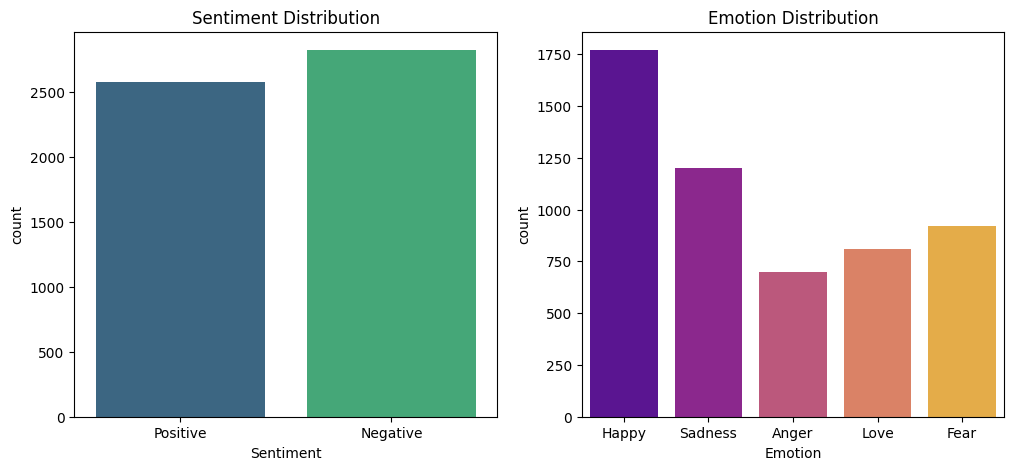

In [27]:
# Visualize distribution of Sentiment and Emotion
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=data, x='Sentiment', palette='viridis')
plt.title("Sentiment Distribution")

plt.subplot(1, 2, 2)
sns.countplot(data=data, x='Emotion', palette='plasma')
plt.title("Emotion Distribution")
plt.show()

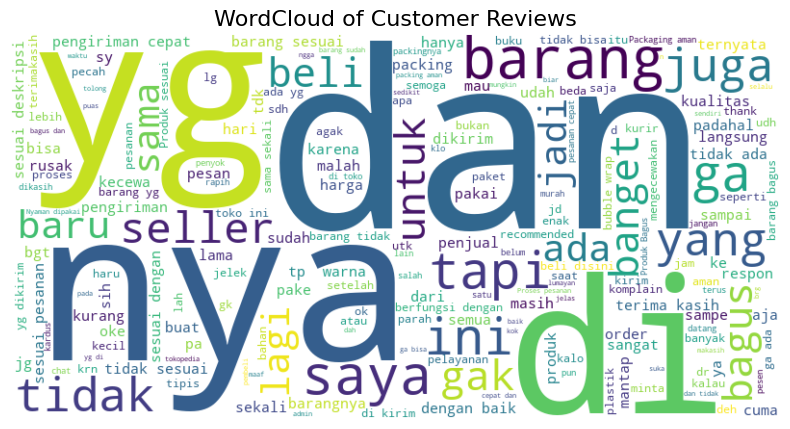

In [28]:
# Generate a wordcloud for customer reviews
text = ' '.join(data['Customer Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Customer Reviews", fontsize=16)
plt.show()

In [29]:
# Splitting the data
X = data['Customer Review']
y_sentiment = data['Sentiment']
y_emotion = data['Emotion']

# Splitting data for Sentiment and Emotion classification
X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(
    X, y_sentiment, test_size=0.2, random_state=42)

X_train_emotion, X_test_emotion, y_train_emotion, y_test_emotion = train_test_split(
    X, y_emotion, test_size=0.2, random_state=42)

In [30]:
# 2. Text preprocessing
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.strip()  # Remove whitespace
    return text

X_train_sentiment = X_train_sentiment.apply(preprocess_text)
X_test_sentiment = X_test_sentiment.apply(preprocess_text)
X_train_emotion = X_train_emotion.apply(preprocess_text)
X_test_emotion = X_test_emotion.apply(preprocess_text)

# 3. Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_sentiment)

In [31]:
# Convert text to sequences
X_train_sentiment_seq = tokenizer.texts_to_sequences(X_train_sentiment)
X_test_sentiment_seq = tokenizer.texts_to_sequences(X_test_sentiment)

X_train_emotion_seq = tokenizer.texts_to_sequences(X_train_emotion)
X_test_emotion_seq = tokenizer.texts_to_sequences(X_test_emotion)

# Padding sequences
max_len = 100
X_train_sentiment_pad = pad_sequences(X_train_sentiment_seq, maxlen=max_len, padding='post')
X_test_sentiment_pad = pad_sequences(X_test_sentiment_seq, maxlen=max_len, padding='post')

X_train_emotion_pad = pad_sequences(X_train_emotion_seq, maxlen=max_len, padding='post')
X_test_emotion_pad = pad_sequences(X_test_emotion_seq, maxlen=max_len, padding='post')

# Encode labels
label_encoder_sentiment = LabelEncoder()
y_train_sentiment_enc = label_encoder_sentiment.fit_transform(y_train_sentiment)
y_test_sentiment_enc = label_encoder_sentiment.transform(y_test_sentiment)

label_encoder_emotion = LabelEncoder()
y_train_emotion_enc = label_encoder_emotion.fit_transform(y_train_emotion)
y_test_emotion_enc = label_encoder_emotion.transform(y_test_emotion)

In [88]:
# 4. Build the LSTM model
def build_model(output_dim):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))
    
    # Add Bidirectional LSTM
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.5))
    
    # Another Bidirectional LSTM Layer
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    
    # Dense Layer with more units
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    
    # Use Adam optimizer with a lower learning rate for stability
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Build the model to initialize layers
    model.build(input_shape=(None, max_len))  # Ensures layers are built correctly
    return model

# Sentiment Model
sentiment_model = build_model(output_dim=len(label_encoder_sentiment.classes_))
print("Sentiment Model Summary:")
sentiment_model.summary()

Sentiment Model Summary:


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 100, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,075,906 (4.10 MB)

 Trainable params: 1,075,906 (4.10 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
# 5. Fit models
history_sentiment = sentiment_model.fit(
    X_train_sentiment_pad, y_train_sentiment_enc,
    validation_data=(X_test_sentiment_pad, y_test_sentiment_enc),
    epochs=20, batch_size=32, verbose=1
)

Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 30s 185ms/step - accuracy: 0.6762 - loss: 0.5904 - val_accuracy: 0.8611 - val_loss: 0.4200
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 29s 214ms/step - accuracy: 0.8869 - loss: 0.3094 - val_accuracy: 0.9250 - val_loss: 0.2071
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - accuracy: 0.9693 - loss: 0.1097 - val_accuracy: 0.9315 - val_loss: 0.2039
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 27s 202ms/step - accuracy: 0.9842 - loss: 0.0564 - val_accuracy: 0.9343 - val_loss: 0.2062
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 28s 204ms/step - accuracy: 0.9867 - loss: 0.0469 - val_accuracy: 0.9296 - val_loss: 0.2215
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 26s 190ms/step - accuracy: 0.9935 - loss: 0.0284 - val_accuracy: 0.9343 - val_loss: 0.2373
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 26s 195ms/step - accuracy: 0.9854 - loss: 0.0528 - val_accuracy: 0.9176 - val_loss: 0.3000
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 27s 203ms/step - accuracy: 0.9885 - loss: 0

In [92]:
# 4. Build the Sentiment LSTM model
def build_model(output_dim):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))
    
    # Add Bidirectional LSTM
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.5))
    
    # Another Bidirectional LSTM Layer
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    
    # Dense Layer with more units
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    
    # Use Adam optimizer with a lower learning rate for stability
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Build the model to initialize layers
    model.build(input_shape=(None, max_len))  # Ensures layers are built correctly
    return model

# Emotion Model
emotion_model = build_model(output_dim=len(label_encoder_emotion.classes_))
print("\nEmotion Model Summary:")
emotion_model.summary()


Emotion Model Summary:


e:\Software\Python\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 100, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,076,101 (4.10 MB)

 Trainable params: 1,076,101 (4.10 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
history_emotion = emotion_model.fit(
    X_train_emotion_pad, y_train_emotion_enc,
    validation_data=(X_test_emotion_pad, y_test_emotion_enc),
    epochs=20, batch_size=32, verbose=1
)

Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.3728 - loss: 1.4843 - val_accuracy: 0.5130 - val_loss: 1.0975
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 23s 167ms/step - accuracy: 0.5151 - loss: 1.0019 - val_accuracy: 0.5519 - val_loss: 1.0076
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - accuracy: 0.6367 - loss: 0.8117 - val_accuracy: 0.5852 - val_loss: 0.9859
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 179ms/step - accuracy: 0.7355 - loss: 0.6330 - val_accuracy: 0.5972 - val_loss: 1.0088
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - accuracy: 0.8105 - loss: 0.4981 - val_accuracy: 0.5972 - val_loss: 1.1143
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 23s 170ms/step - accuracy: 0.8656 - loss: 0.3730 - val_accuracy: 0.5713 - val_loss: 1.3601
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 180ms/step - accuracy: 0.9000 - loss: 0.3012 - val_accuracy: 0.5787 - val_loss: 1.4540
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - accuracy: 0.9236 - loss: 0

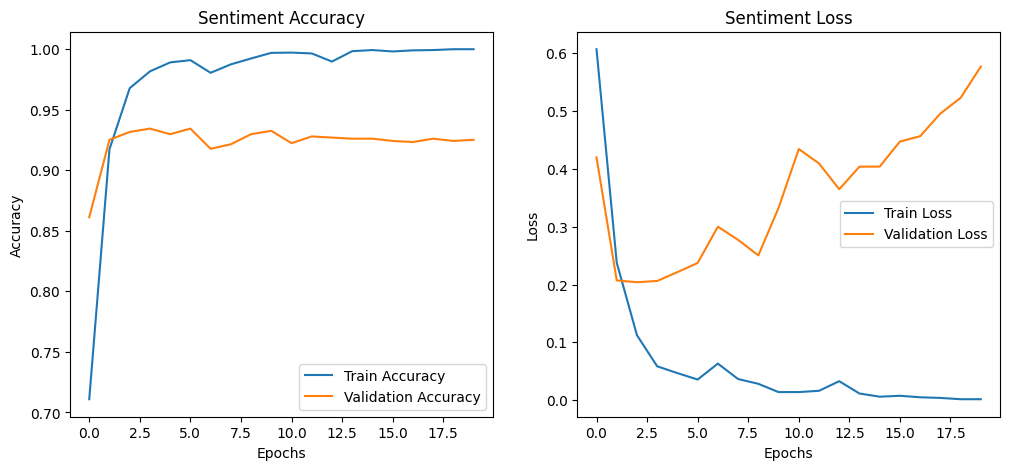

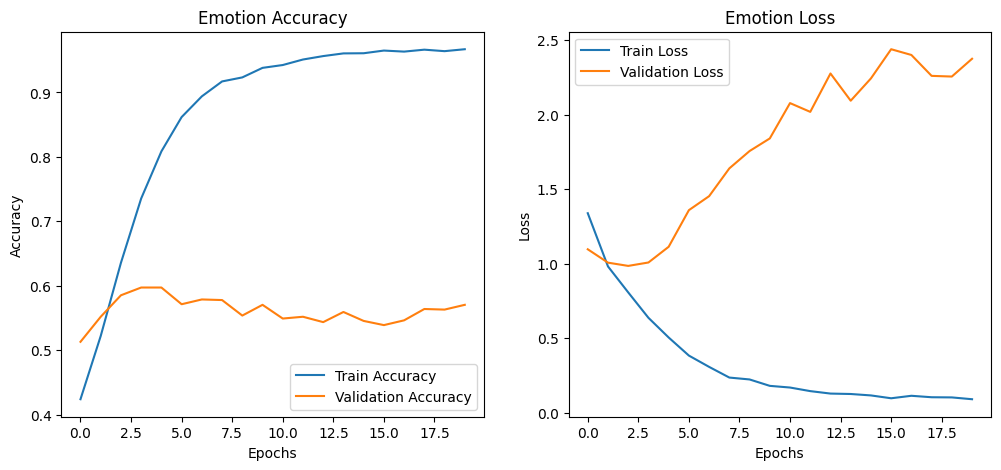

In [94]:
# 6. Plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot for Sentiment
plot_history(history_sentiment, 'Sentiment')

# Plot for Emotion
plot_history(history_emotion, 'Emotion')

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
Classification Report for Sentiment:

              precision    recall  f1-score   support

    Negative       0.91      0.95      0.93       557
    Positive       0.94      0.90      0.92       523

    accuracy                           0.93      1080
   macro avg       0.93      0.92      0.92      1080
weighted avg       0.93      0.93      0.92      1080



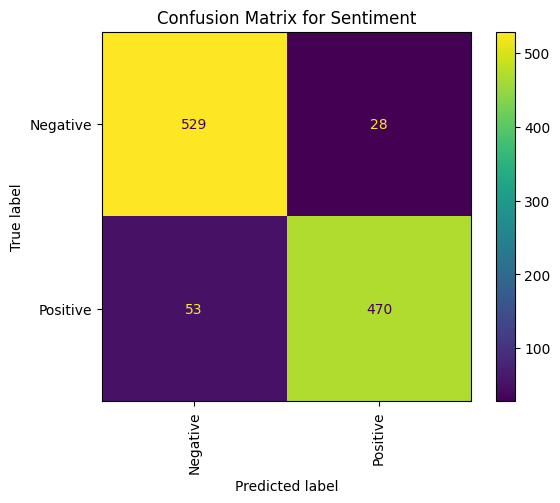

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step
Classification Report for Emotion:

              precision    recall  f1-score   support

       Anger       0.39      0.34      0.36       145
        Fear       0.38      0.45      0.41       159
       Happy       0.73      0.79      0.76       356
        Love       0.57      0.49      0.52       167
     Sadness       0.56      0.53      0.54       253

    accuracy                           0.57      1080
   macro avg       0.53      0.52      0.52      1080
weighted avg       0.57      0.57      0.57      1080



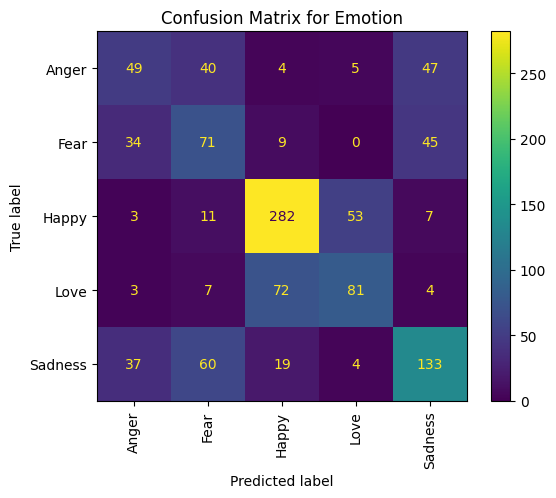

In [95]:
# 5. Classification report and confusion matrix
def evaluate_model(model, X_test, y_test, label_encoder, title):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(f"Classification Report for {title}:\n")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {title}")
    plt.show()

# Evaluate Sentiment Model
evaluate_model(sentiment_model, X_test_sentiment_pad, y_test_sentiment_enc, label_encoder_sentiment, "Sentiment")

# Evaluate Emotion Model
evaluate_model(emotion_model, X_test_emotion_pad, y_test_emotion_enc, label_encoder_emotion, "Emotion")